# Entropy Measure Cut-off using Post Volume

### 1. Preprocess

In [19]:
# Import Modules
import pandas as pd
import numpy as np
from nltk import FreqDist
import sqlite3
import pickle
import math
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm

with open('/data1/StackOverflow/Tag_Analysis/df_tags_2023.pickle', 'rb') as fr:
    df_tags = pickle.load(fr)

def wc(text):
    """
    Cleaning function to be used with our first wordcloud
    """
    
    if text:
        tags = text.replace('><',' ')
        tags = tags.replace('-','')
        tags = tags.replace('.','DOT')
        tags = tags.replace('c++','Cpp')
        tags = tags.replace('c#','Csharp')
        tags = tags.replace('>','')
        return tags.replace('<','')
    else:
        return 'None'
    
def clean_tags(text):
    """
    Cleaning function for tags
    """
    
    if text:
        tags = text.replace('><',' ')
        tags = tags.replace('>','')
        return tags.replace('<','')
    else:
        return 'None'
    
def tag_freq(data):
    tags = data['tags'].str.replace('[\["\]]', '', regex=True)
    tags = [tag for i in tags.apply(lambda x: wc(x)) for tag in i.split(', ')]
    result = FreqDist(tags)
    return result

# Preprocessing
df_tags['creation_date'] = pd.to_datetime(df_tags['creation_date'])
df_tags['year_month'] = df_tags['creation_date'].dt.to_period('D')
df_tags['year_month'] = df_tags['year_month'].astype(str)
year_month = df_tags.year_month.unique()

# load pickle
import pickle
with open('/data1/StackOverflow/diff_in_diff/daily_tagShare_modified.pickle', 'rb') as fr:
    all_keys = pickle.load(fr)

# Split into counts and share vals.
df_count = all_keys.iloc[:,0::2]
df_share = all_keys.drop('tag', axis = 1)
df_share = df_share.iloc[:,0::2]

# df_count로 share 만들어야 함.
tagTrend = {'tagName' : df_count['index'], 'preGPT':
              df_count.iloc[:, 641:731].sum(axis = 1, skipna = True),
              'postGPT' : df_count.iloc[:, 731:].sum(axis = 1, skipna = True)}
tagTrend = pd.DataFrame(tagTrend)
tagTrend['pre_share'] = tagTrend['preGPT'] / tagTrend['preGPT'].sum()
tagTrend['post_share'] = tagTrend['postGPT'] / tagTrend['postGPT'].sum()

# Convert nan to 0
#tagTrend.fillna(0, inplace = True)
tagTrend['diff'] = tagTrend['post_share'] - tagTrend['pre_share']
tagTrend.sort_values('diff', ascending = False)

,tagName,preGPT,postGPT,pre_share,post_share,diff
242,nextDOTjs,3363.0,12004.0,0.002811,0.004239,0.001428
442,springboot,5185.0,15645.0,0.004333,0.005524,0.001191
168,seleniumwebdriver,1149.0,5905.0,0.000960,0.002085,0.001125
29,angular,6128.0,16166.0,0.005121,0.005708,0.000587
10986,openaiapi,58.0,1431.0,0.000048,0.000505,0.000457
...,...,...,...,...,...,...
418,sql,9806.0,18885.0,0.008195,0.006668,-0.001527
28,arrays,6757.0,10368.0,0.005647,0.003661,-0.001986
72,pandas,11336.0,19116.0,0.009474,0.006750,-0.002724
5,javascript,41753.0,85659.0,0.034894,0.030246,-0.004647


### 2. Share Volume Approach

In [20]:
def calculate_entropy(probabilities):
    """ Calculate the Shannon entropy of a given list of probabilities. """
    entropy = 0
    for p in probabilities:
        if p > 0:
            entropy += p * math.log(p, 2)
    return -entropy

In [21]:
# Visualization
def vis_coeff(df_result):
    fig, ax = plt.subplots()
    line, = ax.plot(df_result['cut_off_percentage'].astype(str), df_result['coef'], marker='o', label='Coefficient')  # Added label for legend

    # Adding title and labels
    ax.set_title('Change of Coefficient using Post Volume(E.3.2)')
    ax.set_xlabel('Number of K (Filtered)')
    ax.set_ylabel('Coefficient')

    # Optionally add grid
    ax.grid(True)

    # Adding labels at the top of each point
    for i, txt in enumerate(df_result['volume_outlier'].round(2)):
        ax.text(df_result['cut_off_percentage'].astype(str)[i], df_result['coef'][i]+0.0001, txt, ha='center', va='bottom')

    # Adding text message at the top right corner
    plt.text(1, 0.97, 'The labeled values represent volume of outliers', 
            horizontalalignment='right', 
            verticalalignment='top', 
            transform=ax.transAxes, 
            fontsize=10)
    # Display the plot
    plt.show()

### Further Experience

### This is the final Version

In [22]:
cutoff_List = [0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200]
result_vr6 = pd.DataFrame(columns = ['cut_off_percentage', 'coef', 'std_err', 'P_val', 'volume_outlier'])

for i in range(len(cutoff_List)):
    # filter data without outliers
    cleaned_data = tagTrend.sort_values('pre_share', ascending = False)[cutoff_List[i]:]
    cleansed = all_keys[all_keys['index'].isin(cleaned_data['tagName'])].reset_index(drop = True)
    
    ### Update tag share. ###
    #df_count_tmp = cleansed.iloc[:,0::2]
    #col_sums = df_count_tmp.iloc[:,1:].sum()
    #df_share_tmp = df_count_tmp.iloc[:,1:].div(col_sums, axis = 1)
    #df_share_tmp.insert(0,'index', df_count_tmp['index'])

    # Entropy score
    entropy_Score = []
    '''
    for j in range(1, df_share_tmp.shape[1]):
        arr = np.array(df_share_tmp.iloc[:, j])
        arr = arr/100
        arrList = arr.tolist()
        entropy_Score.append(calculate_entropy(arrList))
    '''
    
    
    for j in range(3, cleansed.shape[1], 2):
        arr = np.array(cleansed.iloc[:, j])
        arr = arr/100
        arrList = arr.tolist()
        entropy_Score.append(calculate_entropy(arrList))


    result_entropy = pd.DataFrame({'year_month':year_month, 'ent_Score':entropy_Score})
    # Model Construction
    entropy = list(result_entropy[(result_entropy['year_month'] > '2021-08-31') &
            (result_entropy['year_month'] < '2023-09-01')].reset_index().ent_Score) # fixed datetime
    # Split Data
    control_data = pd.DataFrame({'entropy' : entropy[:365],
                'T_d': [0]*len(entropy[:365]),
                'P_t' : [0]*90 + [1]*275})
    treated_data = pd.DataFrame({'entropy' : entropy[365:],
                'T_d': [1]*len(entropy[365:]),
                'P_t' : [0]*90 + [1]*275})
    df_did = pd.concat([control_data, treated_data], axis = 0).reset_index(drop = True)
    # Add date and month feature
    df_did['date'] = result_entropy[(result_entropy['year_month'] > '2021-08-31') &
            (result_entropy['year_month'] < '2023-09-01')].reset_index().year_month
    df_did['month'] = pd.to_datetime(df_did['date']).dt.month
    # Apply log
    df_did['ln_y'] = np.log2(df_did['entropy'])
    fname = f"ent_aom_{cutoff_List[i]}.csv"
    df_did.to_csv(fname, index = False)

    # Result Appending
    filename = f"entropy_{cutoff_List[i]}.pkl"
    model2 = sm.ols('ln_y ~ T_d + P_t + T_d * P_t + C(month)', df_did).fit(cov_type='HC3')
    with open(filename, "wb") as file:
        pickle.dump(model2, file)
    result_model_bottomK = pd.DataFrame({'cut_off_percentage':[cutoff_List[i]], 'coef':[model2.params['T_d:P_t']], 'std_err':[model2.bse['T_d:P_t']], 'P_val':[model2.pvalues['T_d:P_t']],
                                         'volume_outlier': [tagTrend.sort_values('pre_share', ascending = False)[:cutoff_List[i]].pre_share.sum()]})
    result_vr6 = pd.concat([result_vr6, result_model_bottomK], ignore_index = True)

/tmp/ipykernel_260146/1724166580.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_vr6 = pd.concat([result_vr6, result_model_bottomK], ignore_index = True)


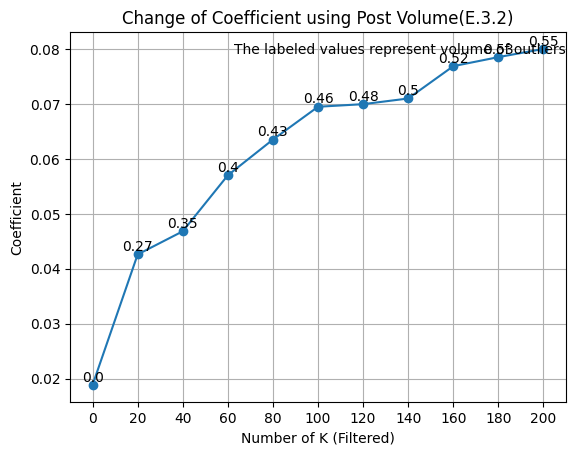

In [23]:
vis_coeff(result_vr6)